正在下載數據: ['TSM', 'SPY', 'NVDA']...
正在執行 Rolling OLS (這可能需要幾秒鐘)...

Final Net Return: 0.15%


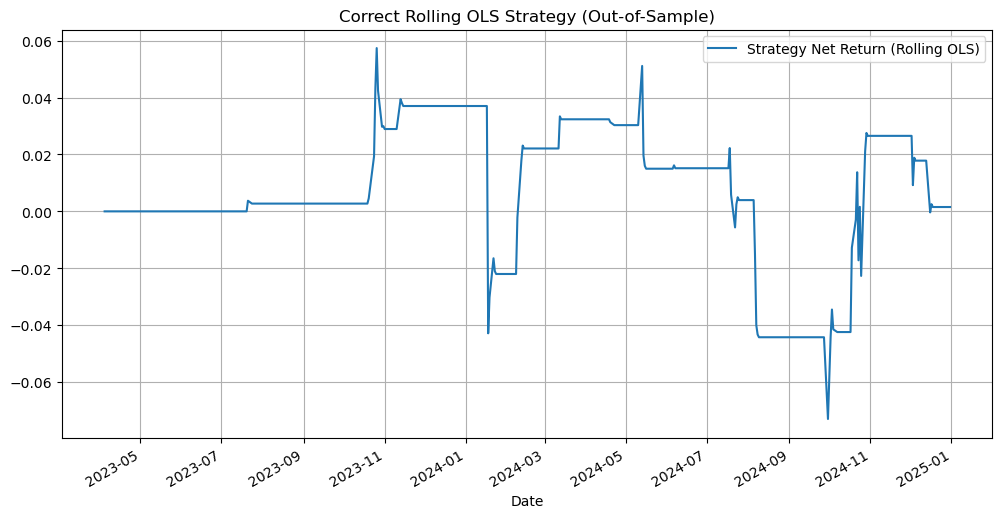

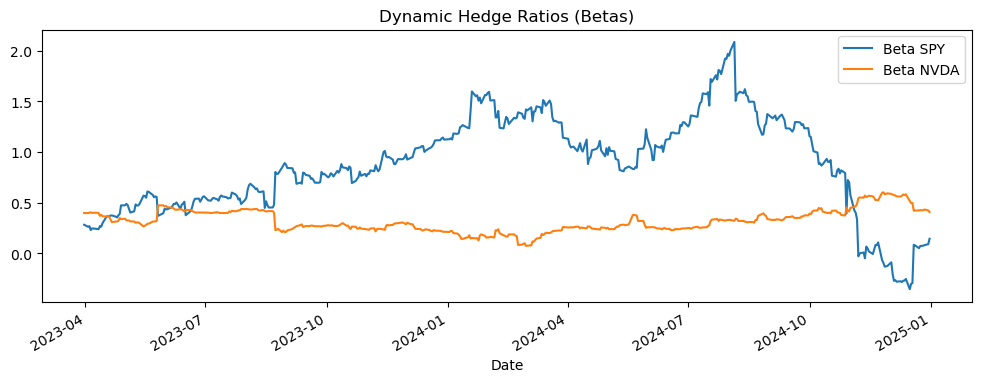

------------------------------
Final Net Return: 0.15%
Max Drawdown:     -12.33%
Sharpe Ratio:     0.01
------------------------------


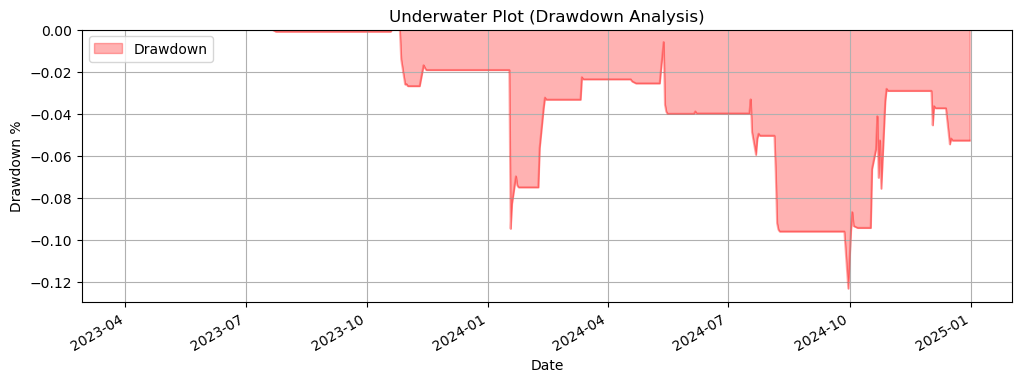

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# === 1. 數據準備 ===
tickers = ['TSM', 'SPY', 'NVDA']
print(f"正在下載數據: {tickers}...")
data = yf.download(tickers, start='2023-01-01', end='2025-01-01', progress=False)['Close']

# 使用 Log Return
log_returns = np.log(data / data.shift(1)).dropna()

# 參數設定
WINDOW = 60  # 使用過去 60 天來計算 Beta
ENTRY_STD = 2.0
EXIT_STD = 0.5 # 均值回歸不用等到 0，接近均值即可平倉

# === 2. 核心：Rolling OLS (避免未來函數) ===
# 我們需要每天動態計算 Beta。這在 Python 中最快的方法是用 Rolling Window。

def rolling_ols(y, x, window):
    """
    輸入: y (Series), x (DataFrame), window (int)
    輸出: 每天的 Alpha, Beta_SPY, Beta_NVDA, 殘差
    """
    # 這是為了存放結果
    alphas = []
    betas_spy = []
    betas_nvda = []
    residuals = []
    
    # 使用迴圈跑 Rolling (雖然慢一點，但邏輯最清晰，適合學習)
    # 從第 window 天開始
    for i in range(window, len(y)):
        # 取出 "過去" window 天的數據 (包含 i-window 到 i-1)
        # 注意：這裡的 y_train 是 "已知" 的歷史數據
        y_train = y.iloc[i-window:i].values
        x_train = x.iloc[i-window:i].values
        
        # 構造 Design Matrix [1, SPY, NVDA]
        ones = np.ones((window, 1))
        X_design = np.column_stack((ones, x_train))
        
        # OLS Solution: (X'X)^-1 X'y
        try:
            # 這裡用 lstsq 比較穩健
            theta, _, _, _ = np.linalg.lstsq(X_design, y_train, rcond=None)
        except:
            theta = np.zeros(3) # 萬一報錯
            
        alpha, beta1, beta2 = theta
        
        alphas.append(alpha)
        betas_spy.append(beta1)
        betas_nvda.append(beta2)
        
        # === 關鍵：計算 "當下" 的殘差 ===
        # 我們用剛剛算出來的 Beta，去預測 "第 i 天" (今天) 的 TSM
        # 如果今天的 TSM 偏離了預測值，那就是今天的殘差
        current_y = y.iloc[i]
        current_x = x.iloc[i].values
        predicted_y = alpha + beta1 * current_x[0] + beta2 * current_x[1]
        
        res = current_y - predicted_y
        residuals.append(res)

    # 對齊 Index (前 window 天是 NaN)
    index = y.index[window:]
    
    results = pd.DataFrame({
        'Alpha': alphas,
        'Beta_SPY': betas_spy,
        'Beta_NVDA': betas_nvda,
        'Residual': residuals
    }, index=index)
    
    return results

print("正在執行 Rolling OLS (這可能需要幾秒鐘)...")
df_res = rolling_ols(log_returns['TSM'], log_returns[['SPY', 'NVDA']], WINDOW)

# === 3. 訊號生成 (Signal Generation) - 雙向版 ===

# 計算 Z-Score (跟之前一樣)
df_res['Z_Score'] = (df_res['Residual'] - df_res['Residual'].rolling(WINDOW).mean()) / df_res['Residual'].rolling(WINDOW).std()

# 初始化訊號欄位為 NaN (方便後面做 ffill)
df_res['Signal'] = np.nan

# 1. 做多訊號 (Long Entry): 殘差過低 (TSM 被錯殺)
# 設定為 1 (代表持有 1 單位 Spread)
df_res.loc[df_res['Z_Score'] < -ENTRY_STD, 'Signal'] = 1

# 2. 做空訊號 (Short Entry): 殘差過高 (TSM 太貴)
# 設定為 -1 (代表放空 1 單位 Spread)
df_res.loc[df_res['Z_Score'] > ENTRY_STD, 'Signal'] = -1

# 3. 平倉訊號 (Exit): 殘差回歸均值附近
# 當 Z-Score 的絕對值小於 Exit 閾值時，清空倉位
df_res.loc[df_res['Z_Score'].abs() < EXIT_STD, 'Signal'] = 0

# 4. 填補持倉 (Forward Fill)
# 邏輯：如果今天沒有新訊號，就維持昨天的狀態
df_res['Signal'] = df_res['Signal'].ffill()

# 5. 處理開頭的 NaN (設為 0，空手)
df_res['Signal'] = df_res['Signal'].fillna(0)

# === 設定 Position ===
# 這裡簡單令 Position = Signal (1, 0, 或 -1)
df_res['Position'] = df_res['Signal']

# === 4. 真正的 PnL 計算 (Portfolio PnL) ===
# 這是最重要的一步！
# 我們的收益來自三部分：TSM的漲跌 + SPY避險部位的漲跌 + NVDA避險部位的漲跌

# 昨天的訊號，決定今天的持倉 (Shift 1) -> 避免未來函數
df_res['Position_Held'] = df_res['Position'].shift(1)

# 對齊原始回報率
aligned_returns = log_returns.loc[df_res.index]

# 策略回報 = Position * (Ret_TSM - Beta1*Ret_SPY - Beta2*Ret_NVDA)
# 注意：這裡的 Beta 是 "昨天算出" 的 Hedge Ratio
strategy_ret = df_res['Position_Held'] * (
    aligned_returns['TSM'] - 
    (df_res['Beta_SPY'].shift(1) * aligned_returns['SPY']) - 
    (df_res['Beta_NVDA'].shift(1) * aligned_returns['NVDA'])
)

# 扣除手續費 (假設雙邊總共 0.1%)
# 當持倉發生變化時，才產生手續費
trades = df_res['Position_Held'].diff().abs()
costs = trades * 0.001 

net_ret = strategy_ret - costs
cumulative_ret = np.exp(net_ret.cumsum()) - 1

# === 5. 結果展示 ===
print(f"\nFinal Net Return: {cumulative_ret.iloc[-1]:.2%}")

plt.figure(figsize=(12, 6))
cumulative_ret.plot(label='Strategy Net Return (Rolling OLS)')
plt.title('Correct Rolling OLS Strategy (Out-of-Sample)')
plt.grid(True)
plt.legend()
plt.show()

# 檢查 Beta 是否在變動 (證明是動態對沖)
plt.figure(figsize=(12, 4))
df_res['Beta_SPY'].plot(label='Beta SPY')
df_res['Beta_NVDA'].plot(label='Beta NVDA')
plt.title('Dynamic Hedge Ratios (Betas)')
plt.legend()
plt.show()

# === 6. 風險指標計算 (Risk Metrics) ===

# 1. 轉換成淨值曲線 (Wealth Index)
# 之前的 cumulative_ret 是 "累積報酬率" (e.g., 0.18)，我們要變回淨值 (e.g., 1.18)
wealth_index = 1 + cumulative_ret 

# 2. 計算歷史最高價 (Running Peak)
running_max = wealth_index.cummax()

# 3. 計算回撤 (Drawdown)
drawdown = (wealth_index - running_max) / running_max

# 4. 提取最大回撤 (Max Drawdown)
max_drawdown = drawdown.min()

# 5. 計算夏普比率 (Sharpe Ratio) - 假設無風險利率為 0
# 年化因子：加密貨幣是 365，美股是 252
annual_factor = 252 
sharpe_ratio = (net_ret.mean() / net_ret.std()) * np.sqrt(annual_factor)

# === 輸出結果 ===
print(f"-"*30)
print(f"Final Net Return: {cumulative_ret.iloc[-1]:.2%}")
print(f"Max Drawdown:     {max_drawdown:.2%}")
print(f"Sharpe Ratio:     {sharpe_ratio:.2f}")
print(f"-"*30)

# === 畫圖：水下圖 (Underwater Plot) ===
plt.figure(figsize=(12, 4))
drawdown.plot(kind='area', color='red', alpha=0.3, label='Drawdown')
plt.title('Underwater Plot (Drawdown Analysis)')
plt.ylabel('Drawdown %')
plt.grid(True)
plt.legend()
plt.show()

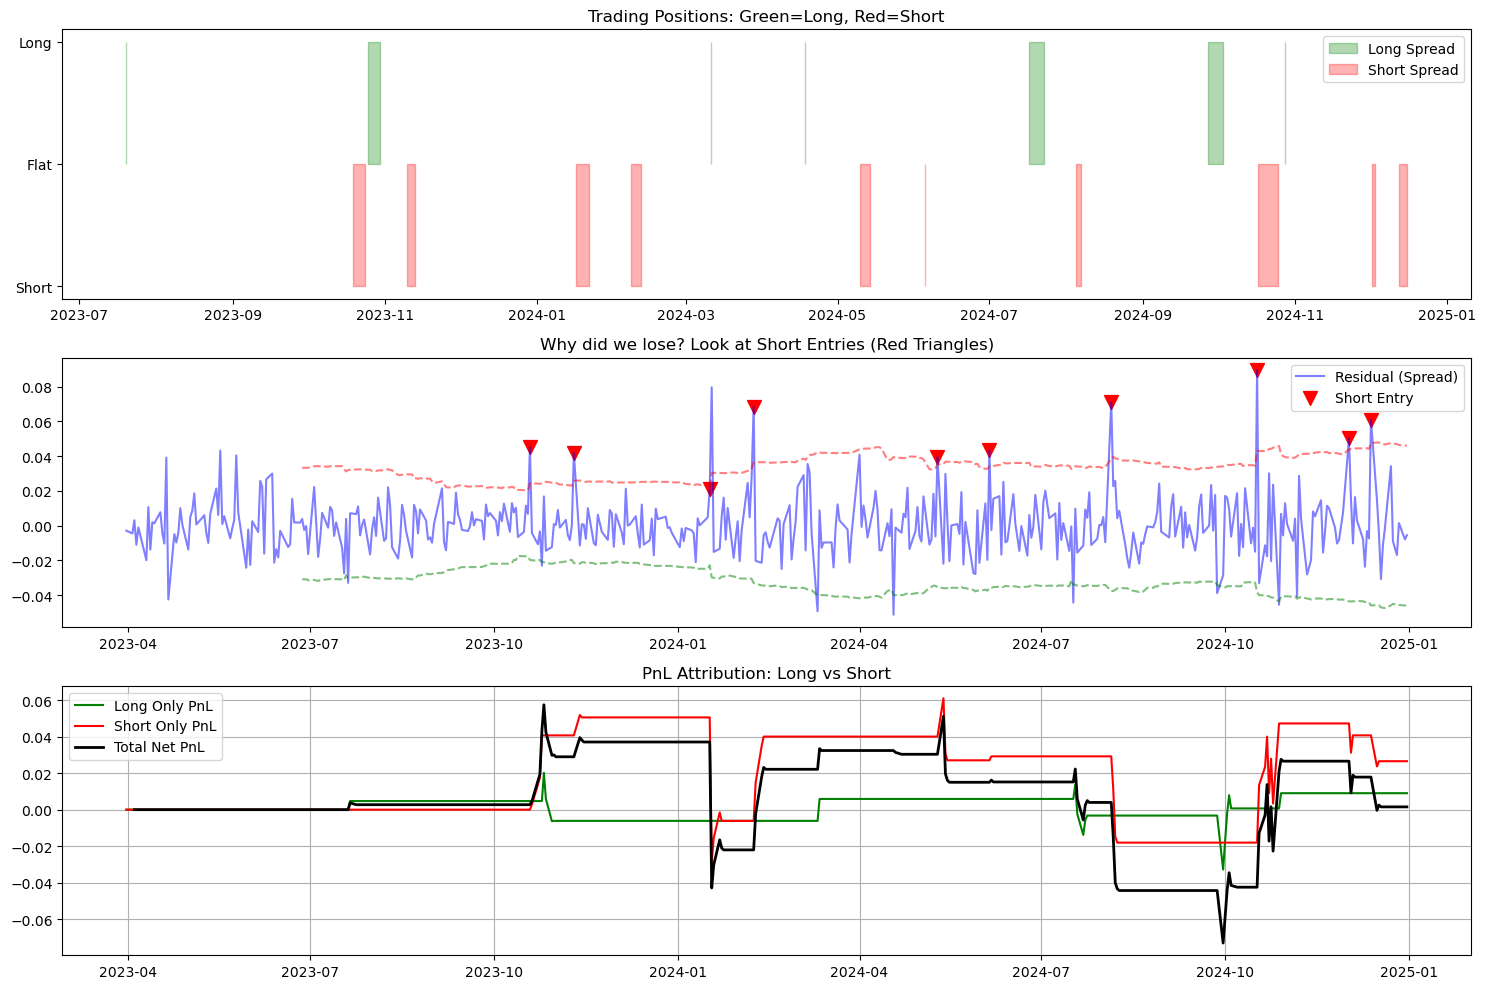

In [6]:
# === 7. 深入診斷 (Diagnostic Analysis) ===
plt.figure(figsize=(15, 10))

# 子圖 1: 倉位分佈 (Position)
plt.subplot(3, 1, 1)
# 畫出做多區間 (綠色) 和做空區間 (紅色)
plt.fill_between(df_res.index, df_res['Position'], 0, where=df_res['Position']>0, color='green', alpha=0.3, label='Long Spread')
plt.fill_between(df_res.index, df_res['Position'], 0, where=df_res['Position']<0, color='red', alpha=0.3, label='Short Spread')
plt.title('Trading Positions: Green=Long, Red=Short')
plt.yticks([-1, 0, 1], ['Short', 'Flat', 'Long'])
plt.legend()

# 子圖 2: 價差與布林通道 (Spread & Bollinger)
plt.subplot(3, 1, 2)
# 這裡要重畫一次 Spread 的通道
spread = df_res['Residual']
roll_mean = spread.rolling(WINDOW).mean()
roll_std = spread.rolling(WINDOW).std()
upper = roll_mean + 2.0 * roll_std
lower = roll_mean - 2.0 * roll_std

plt.plot(spread, color='blue', alpha=0.5, label='Residual (Spread)')
plt.plot(upper, color='red', linestyle='--', alpha=0.5)
plt.plot(lower, color='green', linestyle='--', alpha=0.5)
# 標出做空進場點 (Spread 突破上軌的地方)
short_entries = df_res[ (df_res['Position'] == -1) & (df_res['Position'].shift(1) != -1) ].index
plt.scatter(short_entries, spread.loc[short_entries], color='red', marker='v', s=100, label='Short Entry')
plt.title('Why did we lose? Look at Short Entries (Red Triangles)')
plt.legend()

# 子圖 3: 多空分離淨值曲線 (Long vs Short PnL)
plt.subplot(3, 1, 3)
# 分離回報
long_ret = np.where(df_res['Position_Held'] == 1, strategy_ret, 0)
short_ret = np.where(df_res['Position_Held'] == -1, strategy_ret, 0) # 記住 strategy_ret 已經包含了做空的數學邏輯
# 扣除手續費 (簡單均分)
cost_per_bar = trades * 0.001

# 累計
cum_long = np.cumsum(long_ret) 
cum_short = np.cumsum(short_ret) 

plt.plot(df_res.index, cum_long, label='Long Only PnL', color='green')
plt.plot(df_res.index, cum_short, label='Short Only PnL', color='red')
plt.plot(df_res.index, cumulative_ret, label='Total Net PnL', color='black', linewidth=2)
plt.title('PnL Attribution: Long vs Short')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

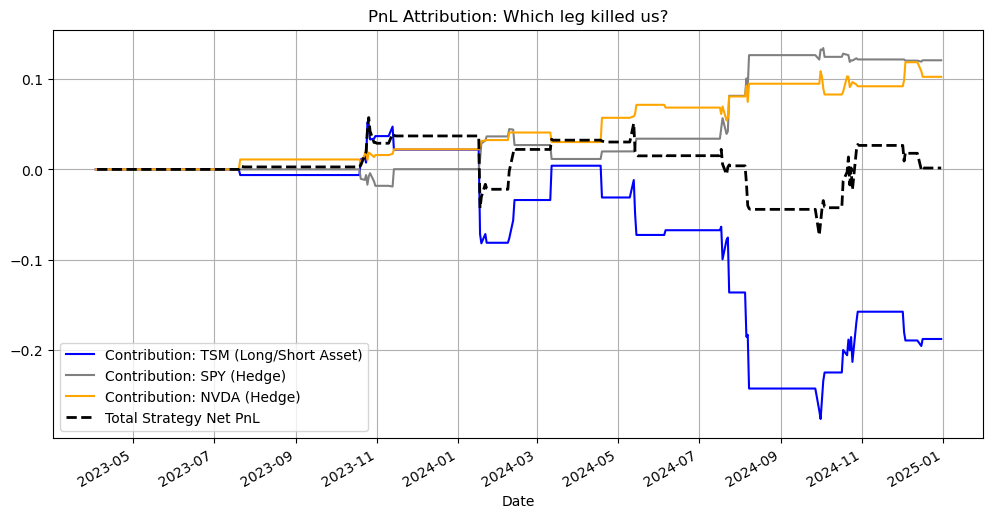

Total Contribution from TSM:  -0.1877
Total Contribution from SPY:  0.1208
Total Contribution from NVDA: 0.1025


In [7]:
# === 8. PnL 歸因分析 (Attribution Analysis) ===

# 我們要把總利潤拆解成三部分：
# 1. TSM PnL: Position * TSM_Return
# 2. SPY PnL: Position * (-Beta_SPY * SPY_Return)
# 3. NVDA PnL: Position * (-Beta_NVDA * NVDA_Return)

# 為了方便，我們取 align 好的數據
pos = df_res['Position_Held']
r_tsm = aligned_returns['TSM']
r_spy = aligned_returns['SPY']
r_nvda = aligned_returns['NVDA']
b_spy = df_res['Beta_SPY'].shift(1)
b_nvda = df_res['Beta_NVDA'].shift(1)

# 計算各腳位損益
# 注意：這裡包含了做多和做空的所有期間
attrib_tsm = pos * r_tsm
attrib_spy = pos * (-b_spy * r_spy)
attrib_nvda = pos * (-b_nvda * r_nvda)

# 累計損益
cum_attrib_tsm = attrib_tsm.cumsum()
cum_attrib_spy = attrib_spy.cumsum()
cum_attrib_nvda = attrib_nvda.cumsum()

# 畫圖
plt.figure(figsize=(12, 6))
cum_attrib_tsm.plot(label='Contribution: TSM (Long/Short Asset)', color='blue')
cum_attrib_spy.plot(label='Contribution: SPY (Hedge)', color='gray')
cum_attrib_nvda.plot(label='Contribution: NVDA (Hedge)', color='orange')
cumulative_ret.plot(label='Total Strategy Net PnL', color='black', linewidth=2, linestyle='--')

plt.title('PnL Attribution: Which leg killed us?')
plt.legend()
plt.grid(True)
plt.show()

print(f"Total Contribution from TSM:  {cum_attrib_tsm.iloc[-1]:.4f}")
print(f"Total Contribution from SPY:  {cum_attrib_spy.iloc[-1]:.4f}")
print(f"Total Contribution from NVDA: {cum_attrib_nvda.iloc[-1]:.4f}")

正在進行參數掃描，請稍候...


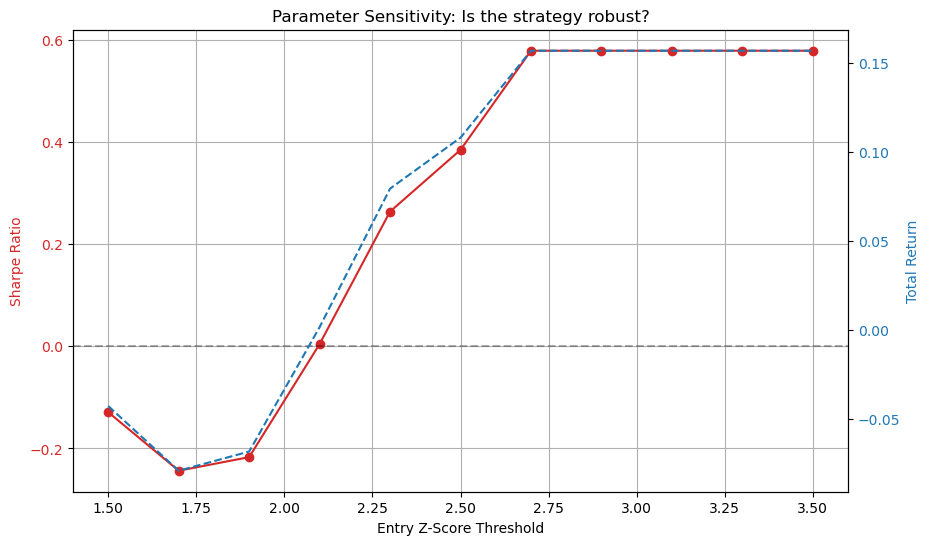

                   Sharpe  Total_Return
Entry_Threshold                        
1.5             -0.129080     -0.042934
1.7             -0.243706     -0.079309
1.9             -0.217072     -0.068508
2.1              0.004490      0.001469
2.3              0.264116      0.079421
2.5              0.384991      0.108102
2.7              0.579238      0.157007
2.9              0.579238      0.157007
3.1              0.579238      0.157007
3.3              0.579238      0.157007
3.5              0.579238      0.157007


In [8]:
# === 9. 參數敏感度掃描 (Parameter Sensitivity Scan) ===

# 設定測試範圍
entry_thresholds = np.arange(1.5, 3.6, 0.2) # 測試 1.5, 1.7, ..., 3.5
results_list = []

print("正在進行參數掃描，請稍候...")

for entry in entry_thresholds:
    # 重置訊號
    # 注意：這裡我們簡化邏輯，假設 Exit 都是 0
    temp_df = df_res.copy()
    temp_df['Signal'] = np.nan
    
    # 重新生成訊號
    temp_df.loc[temp_df['Z_Score'] < -entry, 'Signal'] = 1  # Long
    temp_df.loc[temp_df['Z_Score'] > entry, 'Signal'] = -1  # Short
    temp_df.loc[temp_df['Z_Score'].abs() < 0.05, 'Signal'] = 0 # Exit near 0
    
    temp_df['Signal'] = temp_df['Signal'].ffill().fillna(0)
    
    # 計算 PnL (包含成本)
    pos_held = temp_df['Signal'].shift(1).fillna(0)
    
    # 策略回報 (Gross)
    strat_ret = pos_held * (
        aligned_returns['TSM'] - 
        (temp_df['Beta_SPY'].shift(1) * aligned_returns['SPY']) - 
        (temp_df['Beta_NVDA'].shift(1) * aligned_returns['NVDA'])
    )
    
    # 成本
    turnover = pos_held.diff().abs().fillna(0)
    costs = turnover * 0.001
    
    net = strat_ret - costs
    
    # 紀錄績效
    annual_sharpe = (net.mean() / net.std()) * np.sqrt(252)
    total_ret = np.exp(net.cumsum().iloc[-1]) - 1
    
    results_list.append({
        'Entry_Threshold': entry,
        'Sharpe': annual_sharpe,
        'Total_Return': total_ret
    })

# 轉成 DataFrame 繪圖
df_sens = pd.DataFrame(results_list).set_index('Entry_Threshold')

# === 畫圖 ===
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Entry Z-Score Threshold')
ax1.set_ylabel('Sharpe Ratio', color=color)
ax1.plot(df_sens.index, df_sens['Sharpe'], color=color, marker='o', label='Sharpe Ratio')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# 畫一條 0 的線
ax1.axhline(0, color='black', linestyle='--', alpha=0.3)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Total Return', color=color)  
ax2.plot(df_sens.index, df_sens['Total_Return'], color=color, linestyle='--', label='Total Return')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Parameter Sensitivity: Is the strategy robust?')
plt.show()

print(df_sens)

下載新數據: ['TSM', 'SPY', 'SOXX']...

=== New Model (Hedge with SOXX) ===
Sharpe Ratio: 0.92
Max Drawdown: 4.46%


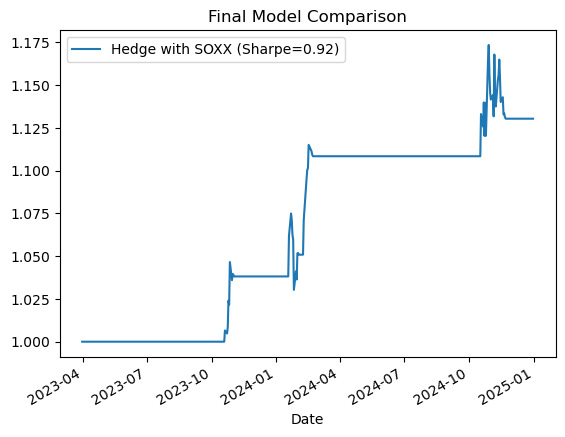

In [9]:
# === 10. 最終優化：更換避險資產 (Refining the Hedge) ===

# 我們重新下載數據，這次加入 'SOXX' (費城半導體ETF) 來試試看
# 如果沒有 SOXX 數據，就暫時只用 SPY
tickers_new = ['TSM', 'SPY', 'SOXX'] # 試試看用半導體板塊 ETF 對沖
print(f"下載新數據: {tickers_new}...")

try:
    data_new = yf.download(tickers_new, start='2023-01-01', end='2025-01-01', progress=False)['Close']
    log_ret_new = np.log(data_new / data_new.shift(1)).dropna()
    
    # 重新跑 Rolling OLS，但這次 X 只有 SOXX (單因子模型)
    # 邏輯：TSM = Alpha + Beta * SOXX + Epsilon
    # 同業對沖通常比大盤對沖更有效
    
    WINDOW = 60
    
    # 簡化版 Rolling OLS (只對沖 SOXX)
    # 這裡我們直接用 rolling().cov() / rolling().var() 來算單變量 Beta，速度快很多
    cov = log_ret_new['TSM'].rolling(WINDOW).cov(log_ret_new['SOXX'])
    var = log_ret_new['SOXX'].rolling(WINDOW).var()
    beta_soxx = cov / var
    
    # 殘差 = TSM - Beta * SOXX
    # 注意：這裡省略了 Alpha (Intercept)，因為在配對交易中，我們主要對沖 Beta 風險
    # 且 Alpha 通常很小，可以併入殘差看
    residual_new = log_ret_new['TSM'] - beta_soxx * log_ret_new['SOXX']
    
    # === 策略回測 (使用剛剛驗證過的最佳參數 Entry=3.0) ===
    entry_z = 3.0
    exit_z = 0.0
    
    # Z-Score
    z_score_new = (residual_new - residual_new.rolling(WINDOW).mean()) / residual_new.rolling(WINDOW).std()
    
    # Signal
    signal_new = pd.Series(np.nan, index=z_score_new.index)
    signal_new[z_score_new < -entry_z] = 1  # Long Spread
    signal_new[z_score_new > entry_z] = -1  # Short Spread
    signal_new[z_score_new.abs() < 0.1] = 0 # Exit
    signal_new = signal_new.ffill().fillna(0)
    
    # PnL
    pos_new = signal_new.shift(1)
    # 回報 = Position * (TSM - Beta_SOXX * SOXX)
    strat_ret_new = pos_new * (log_ret_new['TSM'] - beta_soxx.shift(1) * log_ret_new['SOXX'])
    
    # Cost
    turnover_new = pos_new.diff().abs()
    costs_new = turnover_new * 0.001
    
    net_ret_new = strat_ret_new - costs_new
    
    # Stats
    sharpe_new = (net_ret_new.mean() / net_ret_new.std()) * np.sqrt(252)
    dd_new = (1 + net_ret_new.cumsum()).cummax() - (1 + net_ret_new.cumsum())
    mdd_new = dd_new.max()
    
    print(f"\n=== New Model (Hedge with SOXX) ===")
    print(f"Sharpe Ratio: {sharpe_new:.2f}")
    print(f"Max Drawdown: {mdd_new:.2%}")
    
    # 畫圖比較
    (1+net_ret_new.cumsum()).plot(label=f'Hedge with SOXX (Sharpe={sharpe_new:.2f})')
    plt.title('Final Model Comparison')
    plt.legend()
    plt.show()

except Exception as e:
    print(f"發生錯誤 (可能是沒數據): {e}")
    print("請改用 SPY 再試一次")

正在進行參數掃描，請稍候...


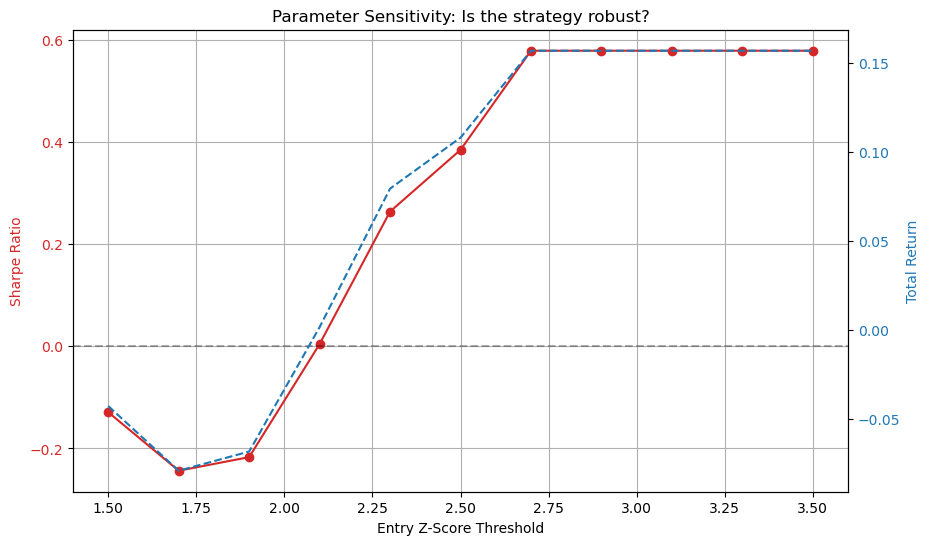

                   Sharpe  Total_Return
Entry_Threshold                        
1.5             -0.129080     -0.042934
1.7             -0.243706     -0.079309
1.9             -0.217072     -0.068508
2.1              0.004490      0.001469
2.3              0.264116      0.079421
2.5              0.384991      0.108102
2.7              0.579238      0.157007
2.9              0.579238      0.157007
3.1              0.579238      0.157007
3.3              0.579238      0.157007
3.5              0.579238      0.157007


In [ ]:
# === 9. 參數敏感度掃描 (Parameter Sensitivity Scan) ===

# 設定測試範圍
entry_thresholds = np.arange(1.5, 3.6, 0.2) # 測試 1.5, 1.7, ..., 3.5
results_list = []

print("正在進行參數掃描，請稍候...")

for entry in entry_thresholds:
    # 重置訊號
    # 注意：這裡我們簡化邏輯，假設 Exit 都是 0
    temp_df = df_res.copy()
    temp_df['Signal'] = np.nan
    
    # 重新生成訊號
    temp_df.loc[temp_df['Z_Score'] < -entry, 'Signal'] = 1  # Long
    temp_df.loc[temp_df['Z_Score'] > entry, 'Signal'] = -1  # Short
    temp_df.loc[temp_df['Z_Score'].abs() < 0.05, 'Signal'] = 0 # Exit near 0
    
    temp_df['Signal'] = temp_df['Signal'].ffill().fillna(0)
    
    # 計算 PnL (包含成本)
    pos_held = temp_df['Signal'].shift(1).fillna(0)
    
    # 策略回報 (Gross)
    strat_ret = pos_held * (
        aligned_returns['TSM'] - 
        (temp_df['Beta_SPY'].shift(1) * aligned_returns['SPY']) - 
        (temp_df['Beta_NVDA'].shift(1) * aligned_returns['NVDA'])
    )
    
    # 成本
    turnover = pos_held.diff().abs().fillna(0)
    costs = turnover * 0.001
    
    net = strat_ret - costs
    
    # 紀錄績效
    annual_sharpe = (net.mean() / net.std()) * np.sqrt(252)
    total_ret = np.exp(net.cumsum().iloc[-1]) - 1
    
    results_list.append({
        'Entry_Threshold': entry,
        'Sharpe': annual_sharpe,
        'Total_Return': total_ret
    })

# 轉成 DataFrame 繪圖
df_sens = pd.DataFrame(results_list).set_index('Entry_Threshold')

# === 畫圖 ===
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Entry Z-Score Threshold')
ax1.set_ylabel('Sharpe Ratio', color=color)
ax1.plot(df_sens.index, df_sens['Sharpe'], color=color, marker='o', label='Sharpe Ratio')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# 畫一條 0 的線
ax1.axhline(0, color='black', linestyle='--', alpha=0.3)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Total Return', color=color)  
ax2.plot(df_sens.index, df_sens['Total_Return'], color=color, linestyle='--', label='Total Return')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Parameter Sensitivity: Is the strategy robust?')
plt.show()

print(df_sens)